In [31]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# Download historical data for SPY
spy_data = yf.download('SPY', start='2010-01-01', end='2023-12-31')

# Reset index to make Date a column
spy_data.reset_index(inplace=True)

# Select relevant features
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
spy_data = spy_data[features]

spy_data['EMA12'] = spy_data['Adj Close'].ewm(span=12, adjust=False).mean()
spy_data['EMA26'] = spy_data['Adj Close'].ewm(span=26, adjust=False).mean()
spy_data['MACD'] = spy_data['EMA12'] - spy_data['EMA26']  # MACD line
spy_data['Signal_Line'] = spy_data['MACD'].ewm(span=9, adjust=False).mean()  # Signal line
spy_data['MACD_Histogram'] = spy_data['MACD'] - spy_data['Signal_Line']  # MACD Histogram

# CCI (Commodity Channel Index)
typical_price = (spy_data['High'] + spy_data['Low'] + spy_data['Adj Close']) / 3
mean_deviation = lambda x: np.mean(np.abs(x - x.mean()))
spy_data['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).apply(mean_deviation))

# ATR (Average True Range)
high_low = spy_data['High'] - spy_data['Low']
high_close = np.abs(spy_data['High'] - spy_data['Adj Close'].shift())
low_close = np.abs(spy_data['Low'] - spy_data['Adj Close'].shift())
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
spy_data['ATR'] = true_range.rolling(window=14).mean()

# Bollinger Bands (BOLL)
spy_data['20_MA'] = spy_data['Adj Close'].rolling(window=20).mean()
spy_data['20_STD'] = spy_data['Adj Close'].rolling(window=20).std()
spy_data['Upper_Band'] = spy_data['20_MA'] + (2 * spy_data['20_STD'])
spy_data['Lower_Band'] = spy_data['20_MA'] - (2 * spy_data['20_STD'])

# EMA20 (20-day Exponential Moving Average)
spy_data['EMA20'] = spy_data['Adj Close'].ewm(span=20, adjust=False).mean()

# MA5 and MA10 (5-day and 10-day Simple Moving Averages)
spy_data['MA5'] = spy_data['Adj Close'].rolling(window=5).mean()
spy_data['MA10'] = spy_data['Adj Close'].rolling(window=10).mean()

# MTM6 and MTM12 (6-month and 12-month Momentum)
spy_data['MTM6'] = spy_data['Adj Close'].pct_change(periods=126)  # Approx. 6 months
spy_data['MTM12'] = spy_data['Adj Close'].pct_change(periods=252)  # Approx. 12 months

# ROC (Rate of Change)
spy_data['ROC'] = spy_data['Adj Close'].pct_change(periods=10) * 100  # 10-day rate of change

# SMI (Stochastic Momentum Index)
low_min = spy_data['Low'].rolling(window=14).min()
high_max = spy_data['High'].rolling(window=14).max()
spy_data['SMI'] = 100 * ((spy_data['Adj Close'] - low_min) / (high_max - low_min))

# WVAD (Williams's Variable Accumulation/Distribution)
spy_data['WVAD'] = ((spy_data['Adj Close'] - spy_data['Low']) - (spy_data['High'] - spy_data['Adj Close'])) / (spy_data['High'] - spy_data['Low']) * spy_data['Volume']

spy_data['Daily_Return'] = spy_data['Adj Close'].pct_change()

for lag in range(1, 6):  # Add 5 lagged returns
    spy_data[f'Return_Lag_{lag}'] = spy_data['Daily_Return'].shift(lag)

spy_data['Rolling_STD'] = spy_data['Adj Close'].rolling(window=10).std()

# Drop the 'Adj Close' column
spy_data.drop(['Adj Close'], axis=1, inplace=True)

# Drop NaN values
spy_data.dropna(inplace=True)

print(spy_data.head())

# Convert to NumPy array
data = spy_data.values
print("Dataset shape:", data.shape)  # (num_days, num_features)
print(data)


[*********************100%***********************]  1 of 1 completed

Price         Open        High         Low     Volume      EMA12      EMA26  \
Ticker         SPY         SPY         SPY        SPY                         
252     126.709999  127.599998  125.699997  138725200  97.366561  96.159603   
253     127.330002  127.370003  126.190002  137409700  97.557985  96.341175   
254     126.580002  127.720001  126.459999  133975300  97.798814  96.547264   
255     127.690002  127.830002  127.010002  122519000  97.972722  96.723704   
256     127.559998  127.769997  126.150002  156034600  98.090007  96.872695   

Price       MACD Signal_Line MACD_Histogram         CCI  ...       ROC  \
Ticker                                                   ...             
252     1.206958    1.194116       0.012842  143.707451  ...  2.212384   
253     1.216810    1.198655       0.018156  133.953305  ...  1.910105   
254     1.251551    1.209234       0.042317  147.503981  ...  1.794382   
255     1.249018    1.217191       0.031827  148.547759  ...  1.280015   
25


/var/folders/0f/1mt731m54b51gldjgy_zszqr0000gn/T/ipykernel_6431/452756807.py:65: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(['Adj Close'], axis=1, inplace=True)


In [33]:
def create_sequences_with_target(data, time_steps, target_column):
    """
    Create sequences and separate target class.

    Args:
    - data: NumPy array of shape (num_days, num_features).
    - time_steps: Number of days per sequence.
    - target_column: Column index for the target variable.

    Returns:
    - X: Input sequences of shape (num_samples, time_steps, num_features-1).
    - y: Target values of shape (num_samples,).
    """
    sequences = []
    targets = []

    for i in range(len(data) - time_steps):
        # Extract a sequence of `time_steps`
        sequence = data[i:i + time_steps]
        sequences.append(sequence)

        # Target is the `adj close` (or target_column) for the next day (day 61)
        target = data[i + time_steps, target_column]
        targets.append(target)

    return np.array(sequences), np.array(targets)

# Create sequences with 30 time steps and separate target (Daily_Return is the last column)
time_steps = 1
target_column = 23 # Assuming 'Daily_Return' is the 6th column (index 5)

X, y = create_sequences_with_target(data, time_steps, target_column)

print("Shape of X:", X.shape)  # (num_samples, time_steps, num_features-1)
print("Shape of y:", y.shape)  # (num_samples,)


Shape of X: (3269, 1, 30)
Shape of y: (3269,)


In [34]:
print(spy_data.iloc[:, 21])

252    -651.553524
253    -652.966052
254    -620.317821
255    -620.717505
256    -655.712635
           ...    
3517     69.084091
3518     75.871368
3519     77.410545
3520     73.878359
3521     63.051760
Name: (SMI, ), Length: 3270, dtype: float64


In [35]:
from sklearn.preprocessing import StandardScaler

# Flatten the data to 2D for normalization
num_samples, time_steps, num_features = X.shape
X_flat = X.reshape(-1, num_features)  # Shape: (samples * time_steps, num_features)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler and transform the data
X_standardized_flat = scaler.fit_transform(X_flat)

# Reshape back to the original 3D shape
X_standardized = X_standardized_flat.reshape(num_samples, time_steps, num_features)

print("Shape of X_standardized:", X_standardized.shape)  # (num_samples, time_steps, num_features)

X = X_standardized


Shape of X_standardized: (3269, 1, 30)


In [36]:
from sklearn.model_selection import train_test_split

# Define the split ratio
test_size = 0.2  # 20% for validation

# Split the data (X and y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)

print("Shape of X_train:", X_train.shape)  # Training features
print("Shape of X_val:", X_val.shape)      # Validation features
print("Shape of y_train:", y_train.shape)  # Training targets
print("Shape of y_val:", y_val.shape)      # Validation targets


Shape of X_train: (2615, 1, 30)
Shape of X_val: (654, 1, 30)
Shape of y_train: (2615,)
Shape of y_val: (654,)


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

def create_bidirectional_lstm(input_shape, units=2048, dropout_rate=0.2):
    
    model = Sequential()

    # Bidirectional LSTM Layer
    model.add(Bidirectional(LSTM(units, return_sequences=True), input_shape=input_shape))

    # Dropout for regularization


    model.add(Bidirectional(LSTM(units // 2, return_sequences=True)))


    model.add(Bidirectional(LSTM(units // 4, return_sequences=False)))

    # Dense output layer
    model.add(Dense(1, activation='linear'))  # Linear activation for regression tasks

    # Set a custom learning rate
    learning_rate = 0.001  # Default for Adam is 0.001, adjust as needed
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model with the custom optimizer
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model


/opt/anaconda3/envs/sp500/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - loss: 2.2861e-04 - mae: 0.0108 - val_loss: 1.6153e-04 - val_mae: 0.0094
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - loss: 1.2810e-04 - mae: 0.0076 - val_loss: 2.0135e-04 - val_mae: 0.0107
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - loss: 1.2069e-04 - mae: 0.0073 - val_loss: 1.5462e-04 - val_mae: 0.0095
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 1.3949e-04 - mae: 0.0075 - val_loss: 1.5631e-04 - val_mae: 0.0096
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 1.1383e-04 - mae: 0.0072 - val_loss: 1.8224e-04 - val_mae: 0.0099
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 1.1958e-04 - mae: 0.0073 - val_loss: 1.3521e-04 - val_mae: 0.0086
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - loss: 1.0697e-04 - mae: 0.0069 - val_loss: 2.2391e-04 - val_mae: 0.0110
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 1.0270e-04 - mae: 0.0070 - val_loss: 1.5598e-04 - val_mae

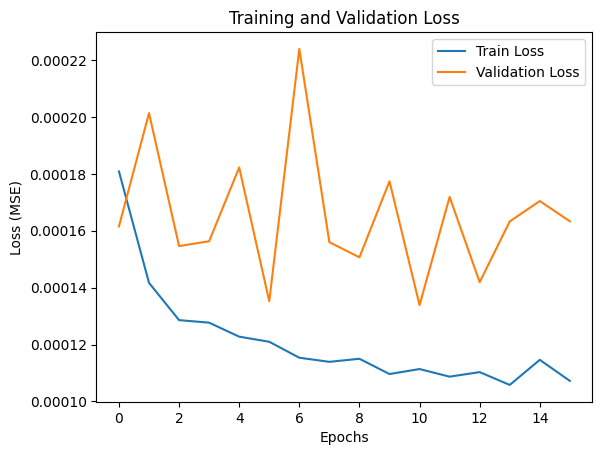

In [38]:
# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_features)

# Create the model
model = create_bidirectional_lstm(input_shape=input_shape)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Adjust as needed
    batch_size=64,  # Adjust as needed
    verbose=1,  # 1 shows progress after each epoch
    callbacks=[early_stopping]  # Include early stopping
)

# Evaluate the model
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss (MSE): {val_loss}")
print(f"Validation MAE: {val_mae}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [39]:
import numpy as np
import pandas as pd

# Predict returns for the validation set
y_pred = model.predict(X_val).flatten()  # Predicted returns (flattened to 1D)
y_true = y_val  # True returns from validation set

# Initialize variables
position = 0  # Current position: 1 = in the market, 0 = out of the market
cumulative_return = 1  # Starting with 1 (100% initial capital)
strategy_returns = []  # To store daily returns from the strategy

# Iterate over the predicted and true returns
for pred_return, true_return in zip(y_pred, y_true):
    if pred_return > 0 and position == 0:
        # Buy if predicted return is positive and currently out of the market
        position = 1
    elif pred_return < 0 and position == 1:
        # Sell if predicted return is negative and currently in the market
        position = 0
    
    # Calculate daily return based on true return if in the market
    daily_return = true_return if position == 1 else 0
    strategy_returns.append(daily_return)

    # Update cumulative return
    cumulative_return *= (1 + daily_return)

# Convert strategy returns to a DataFrame for analysis
strategy_df = pd.DataFrame({
    "True Return": y_true,
    "Predicted Return": y_pred,
    "Strategy Return": strategy_returns
})

# Print cumulative return
print(f"Cumulative Return: {cumulative_return - 1:.2%}")  # As a percentage


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Cumulative Return: 19.88%


In [40]:
# Calculate true cumulative return (buy-and-hold strategy)
true_cumulative_return = np.prod(1 + y_true) - 1  # Compounded return

# Calculate strategy cumulative return
strategy_cumulative_return = np.prod(1 + np.array(strategy_returns)) - 1  # Compounded return

print(f"True Buy-and-Hold Cumulative Return: {true_cumulative_return:.2%}")
print(f"Strategy Cumulative Return: {strategy_cumulative_return:.2%}")


True Buy-and-Hold Cumulative Return: 18.42%
Strategy Cumulative Return: 19.88%


In [41]:
# Directional Accuracy
directional_accuracy = np.mean((y_pred > 0) == (y_val > 0))
print(f"Directional Accuracy: {directional_accuracy:.2%}")

print(f"Mean of Predicted Returns: {np.mean(y_pred)}")
print(f"Mean of Actual Returns: {np.mean(y_val)}")



Directional Accuracy: 52.29%
Mean of Predicted Returns: 0.0025993329472839832
Mean of Actual Returns: 0.0003229177471119432


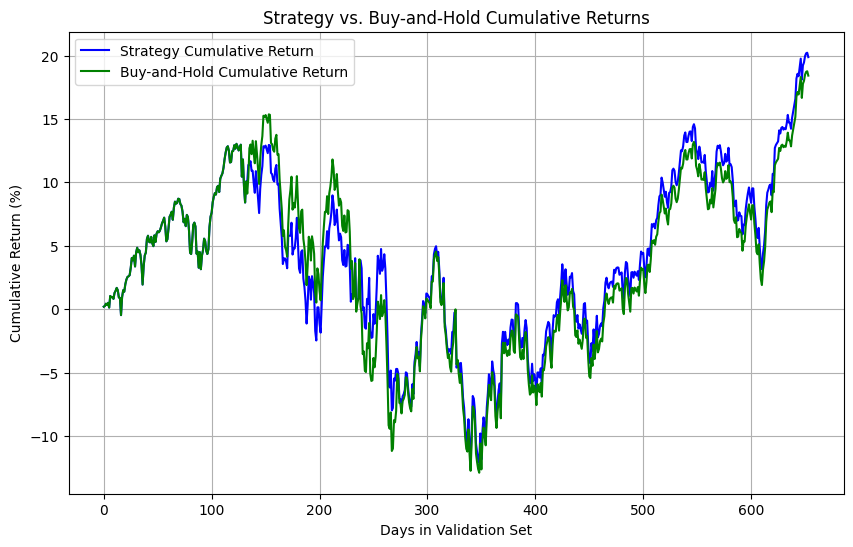

In [42]:
# Calculate cumulative returns for plotting
strategy_cumulative = (np.cumprod(1 + np.array(strategy_returns)) - 1) * 100
true_cumulative = (np.cumprod(1 + y_true) - 1) * 100

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(strategy_cumulative, label="Strategy Cumulative Return", color='blue')
plt.plot(true_cumulative, label="Buy-and-Hold Cumulative Return", color='green')
plt.xlabel("Days in Validation Set")
plt.ylabel("Cumulative Return (%)")
plt.title("Strategy vs. Buy-and-Hold Cumulative Returns")
plt.legend()
plt.grid()
plt.show()


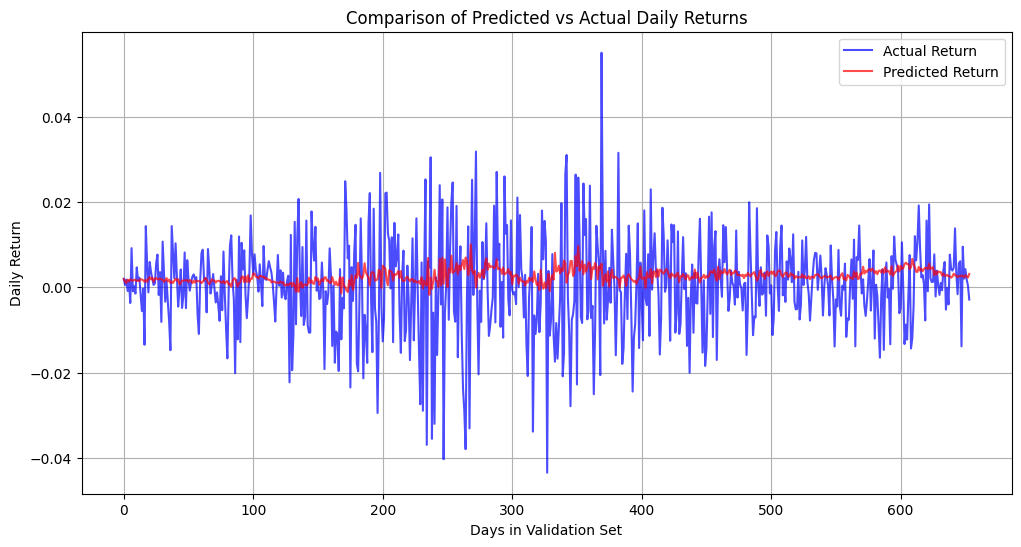

In [43]:
import matplotlib.pyplot as plt

# Plot predicted vs. actual returns
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual Return', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Return', color='red', alpha=0.7)
plt.xlabel("Days in Validation Set")
plt.ylabel("Daily Return")
plt.title("Comparison of Predicted vs Actual Daily Returns")
plt.legend()
plt.grid()
plt.show()


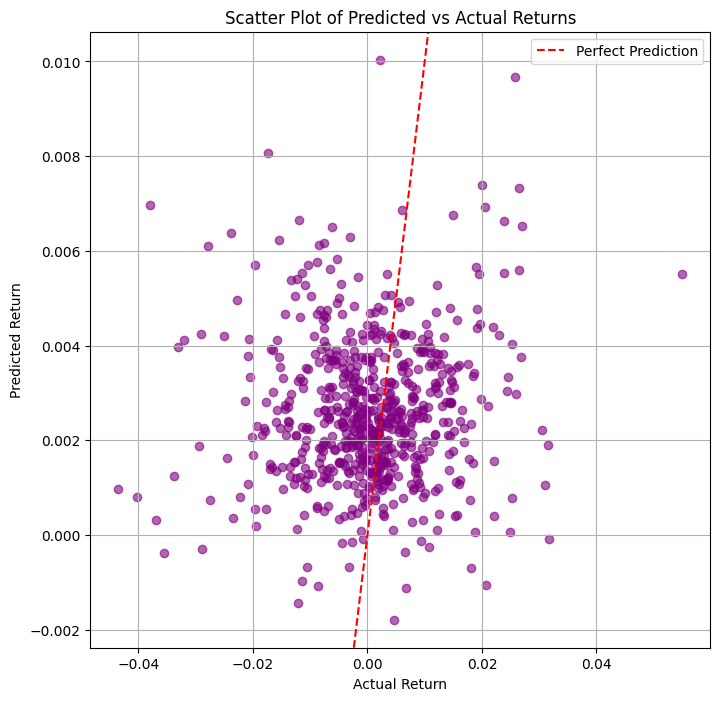

In [44]:
import numpy as np

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred, alpha=0.6, color='purple')
plt.axline((0, 0), slope=1, color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel("Actual Return")
plt.ylabel("Predicted Return")
plt.title("Scatter Plot of Predicted vs Actual Returns")
plt.legend()
plt.grid()
plt.show()


In [45]:
import seaborn as sns
import numpy as np

# Reshape for visualization (if needed)
error_matrix = np.reshape(y_val - y_pred, (-1, 10))  # Example: Reshape into 10 columns

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(error_matrix, cmap="coolwarm", center=0)
plt.title("Heatmap of Prediction Errors")
plt.xlabel("Columns (Grouped Days)")
plt.ylabel("Rows")
plt.show()


ValueError: cannot reshape array of size 654 into shape (10)

In [109]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate metrics
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
correlation = np.corrcoef(y_val, y_pred)[0, 1]  # Correlation coefficient

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Correlation Coefficient: {correlation:.2f}")


Mean Squared Error (MSE): 0.000172
Mean Absolute Error (MAE): 0.010269
Correlation Coefficient: 0.01
